In [146]:
#import files
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
# Load the data into a dataframe and read the first five rows
df = pd.read_csv('./data/combined_dta.csv', encoding='ISO-8859-1', low_memory=False)
df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,see_all,see_all-href,review_title,review,ratings,user_name,date,see_all_link,see_all_link-href,Category
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLaptop Skin Wrap Vinyl from 12-17.0 inches Laptops (Support All Brands)KSh 699 - KSh 797KSh 1,000 - KSh 1,20034%",https://www.jumia.co.ke/generic-laptop-skin-wrap-vinyl-from-12-17.0-inches-laptops-support-all-brands-205863635.html,Laptop Skin Wrap Vinyl from 12-17.0 inches Laptops (Support All Brands),https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/53/6368502/1.jpg?5414,KSh 699 - KSh 797,NaN,NaN,https://www.jumia.co.ke/computer-accessories/?page=50#catalog-listing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand PadKSh 3,325KSh 3,5005%4.1 out of 5(7)",https://www.jumia.co.ke/9-17-laptop-cooling-stand-pad-generic-mpg274804.html,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/68/422543/1.jpg?6874,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?page=50#catalog-listing,See All,https://www.jumia.co.ke/catalog/productratingsreviews/sku/GE840EA14QJ67NAFAMZ/,OKAY,"Working, feels cheap",3 out of 5,by WILFRED,28/04/2022,NaN,NaN,Computing
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand PadKSh 3,325KSh 3,5005%4.1 out of 5(7)",https://www.jumia.co.ke/9-17-laptop-cooling-stand-pad-generic-mpg274804.html,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/68/422543/1.jpg?6874,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?page=50#catalog-listing,See All,https://www.jumia.co.ke/catalog/productratingsreviews/sku/GE840EA14QJ67NAFAMZ/,okay,A bit big for a regular laptop bag... The fancy blue light isn't required and should have added more USB ports like type C. The adjustable metal level is too cheap. Can be made better.,4 out of 5,by Michael,8/7/2021,NaN,NaN,Computing
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop SSDKSh 3,799KSh 5,00024%",https://www.jumia.co.ke/lexar-2.5-sata-256gb-laptop-ssd-264361033.html,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/33/0163462/1.jpg?2271,"KSh 3,799",Lexar,NaN,https://www.jumia.co.ke/computer-accessories/?page=50#catalog-listing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-hard-drive-2tb-153419859.html,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/95/8914351/1.jpg?2036,"KSh 15,000",WD,NaN,https://www.jumia.co.ke/computer-accessories/?page=50#catalog-listing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing


In [148]:
# Read the columns in the dataset
df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'link', 'link-href',
       'see_all', 'see_all-href', 'review_title', 'review', 'ratings',
       'user_name', 'date', 'see_all_link', 'see_all_link-href', 'Category'],
      dtype='object')

In [149]:
# Gets the number of rows and columns in the dataset
df.shape

(60464, 20)

In [150]:
# Check the data type held by each column and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60464 entries, 0 to 60463
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   web-scraper-order      60464 non-null  object
 1   web-scraper-start-url  60464 non-null  object
 2   product                60464 non-null  object
 3   product-href           60464 non-null  object
 4   product_name           60459 non-null  object
 5   image                  60330 non-null  object
 6   price                  60330 non-null  object
 7   brand                  39584 non-null  object
 8   link                   28139 non-null  object
 9   link-href              36020 non-null  object
 10  see_all                40431 non-null  object
 11  see_all-href           40425 non-null  object
 12  review_title           37705 non-null  object
 13  review                 40201 non-null  object
 14  ratings                37618 non-null  object
 15  user_name          

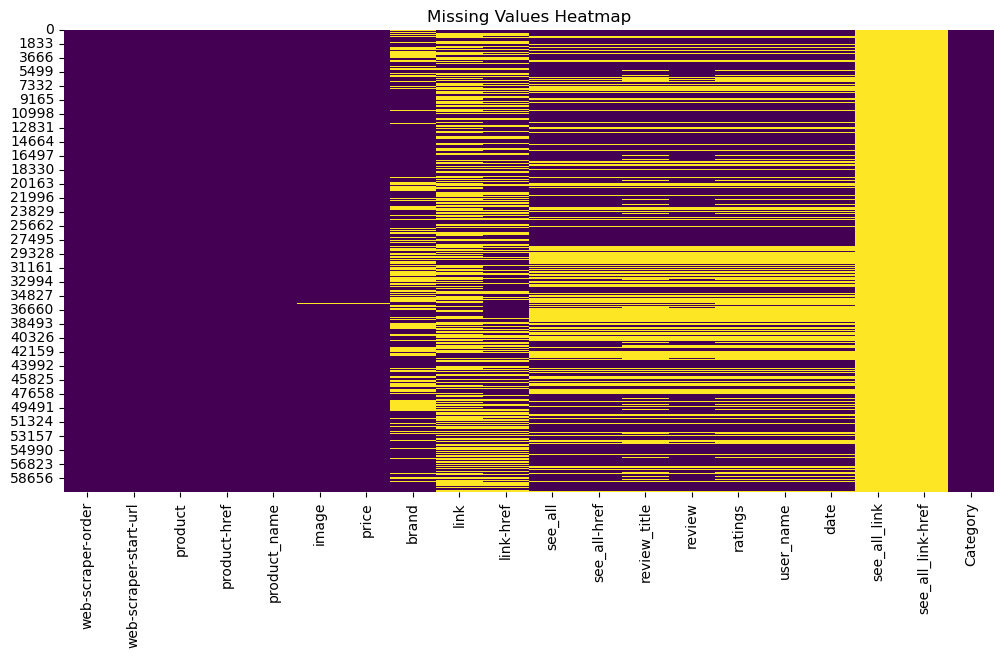

In [151]:
# Plot missing values as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [152]:
# Checks for row duplicates
df.duplicated().sum()

53

In [153]:
# Remove row duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [154]:
df.drop(['see_all_link-href', 'see_all_link', 'see_all-href', 'see_all', 'link-href', 'link'], axis=1, inplace=True,)
df.shape

(60411, 14)

In [155]:
df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'review_title', 'review',
       'ratings', 'user_name', 'date', 'Category'],
      dtype='object')

In [156]:
df['ratings'] = df['ratings'].str.extract(r'(\d+)').astype(float)


In [157]:
df['ratings'].describe()

count    37567.000000
mean         4.056645
std          1.358270
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [158]:
pd.set_option('display.max_colwidth', None)  # Display full length of each column
pd.set_option('display.max_rows', 100)       # Adjust the row limit as needed
pd.set_option('display.max_columns', None)   # Show all columns in the DataFrame

In [159]:
df['web-scraper-start-url']

0           https://www.jumia.co.ke/computer-accessories/
1           https://www.jumia.co.ke/computer-accessories/
2           https://www.jumia.co.ke/computer-accessories/
3           https://www.jumia.co.ke/computer-accessories/
4           https://www.jumia.co.ke/computer-accessories/
                               ...                       
60459    https://www.jumia.co.ke/aromatherapy-fragrances/
60460    https://www.jumia.co.ke/aromatherapy-fragrances/
60461    https://www.jumia.co.ke/aromatherapy-fragrances/
60462    https://www.jumia.co.ke/aromatherapy-fragrances/
60463    https://www.jumia.co.ke/aromatherapy-fragrances/
Name: web-scraper-start-url, Length: 60411, dtype: object

In [160]:
df['sub_category'] = df['web-scraper-start-url'].str.extract(r'\/([^\/]+)\/?$')
df['sub_category']

0           computer-accessories
1           computer-accessories
2           computer-accessories
3           computer-accessories
4           computer-accessories
                  ...           
60459    aromatherapy-fragrances
60460    aromatherapy-fragrances
60461    aromatherapy-fragrances
60462    aromatherapy-fragrances
60463    aromatherapy-fragrances
Name: sub_category, Length: 60411, dtype: object

In [161]:
df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,review_title,review,ratings,user_name,date,Category,sub_category
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLaptop Skin Wrap Vinyl from 12-17.0 inches Laptops (Support All Brands)KSh 699 - KSh 797KSh 1,000 - KSh 1,20034%",https://www.jumia.co.ke/generic-laptop-skin-wrap-vinyl-from-12-17.0-inches-laptops-support-all-brands-205863635.html,Laptop Skin Wrap Vinyl from 12-17.0 inches Laptops (Support All Brands),https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/53/6368502/1.jpg?5414,KSh 699 - KSh 797,NaN,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand PadKSh 3,325KSh 3,5005%4.1 out of 5(7)",https://www.jumia.co.ke/9-17-laptop-cooling-stand-pad-generic-mpg274804.html,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/68/422543/1.jpg?6874,"KSh 3,325",NaN,OKAY,"Working, feels cheap",3.0,by WILFRED,28/04/2022,Computing,computer-accessories
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand PadKSh 3,325KSh 3,5005%4.1 out of 5(7)",https://www.jumia.co.ke/9-17-laptop-cooling-stand-pad-generic-mpg274804.html,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/68/422543/1.jpg?6874,"KSh 3,325",NaN,okay,A bit big for a regular laptop bag... The fancy blue light isn't required and should have added more USB ports like type C. The adjustable metal level is too cheap. Can be made better.,4.0,by Michael,8/7/2021,Computing,computer-accessories
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop SSDKSh 3,799KSh 5,00024%",https://www.jumia.co.ke/lexar-2.5-sata-256gb-laptop-ssd-264361033.html,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/33/0163462/1.jpg?2271,"KSh 3,799",Lexar,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-hard-drive-2tb-153419859.html,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/95/8914351/1.jpg?2036,"KSh 15,000",WD,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories


In [166]:
# Extract overall ratings and ratings count
df['overall_ratings'] = df['product'].str.extract(r'(\d+(\.\d+)?) out of 5')[0]
df['ratings_count'] = df['product'].str.extract(r'(\d+) out of 5\((\d+)\)')[1].astype(float)

print(df[['overall_ratings', 'ratings_count']])



      overall_ratings  ratings_count
0                 NaN            NaN
1                 4.1            7.0
2                 4.1            7.0
3                 NaN            NaN
4                 NaN            NaN
...               ...            ...
60459             NaN            NaN
60460               4            5.0
60461             NaN            NaN
60462             3.5            8.0
60463             3.5            8.0

[60411 rows x 2 columns]


In [129]:
df.shape

(60411, 17)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60411 entries, 0 to 60463
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   web-scraper-order      60411 non-null  object 
 1   web-scraper-start-url  60411 non-null  object 
 2   product                60411 non-null  object 
 3   product-href           60411 non-null  object 
 4   product_name           60406 non-null  object 
 5   image                  60281 non-null  object 
 6   price                  60281 non-null  object 
 7   brand                  39531 non-null  object 
 8   review_title           37656 non-null  object 
 9   review                 40152 non-null  object 
 10  ratings                37567 non-null  float64
 11  user_name              37569 non-null  object 
 12  date                   37569 non-null  object 
 13  Category               60411 non-null  object 
 14  sub_category           60101 non-null  object 
 15  overall

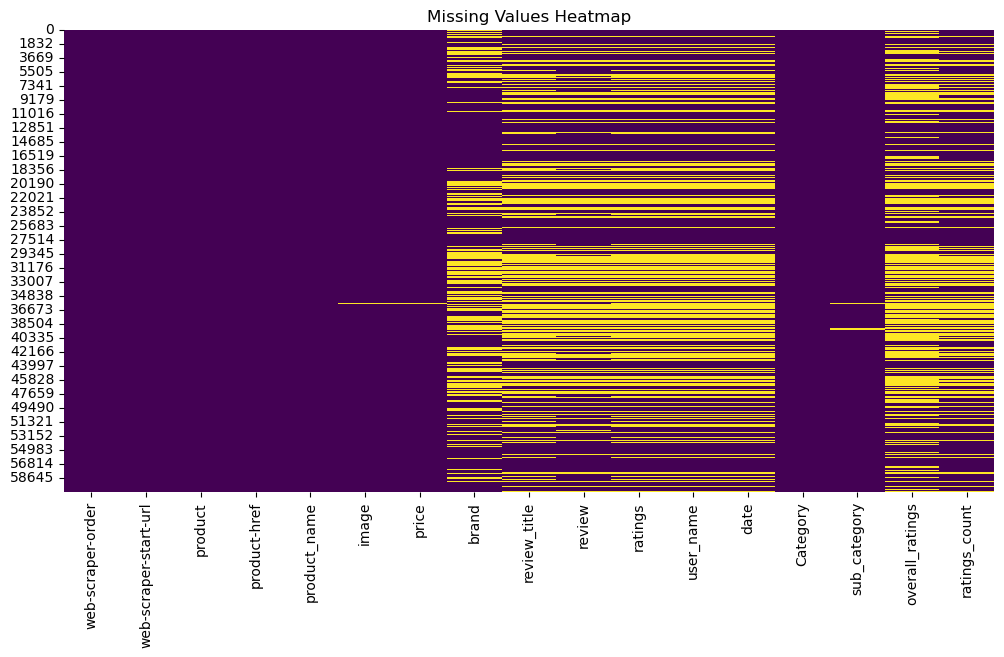

In [131]:
# Plot missing values as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [132]:
# Function that calculates the percentage of null values in every column and displays the series.
def null_percentages(df): 

    # Calculate the number of missing values and their percentage
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / df.shape[0]) * 100   

    # Create a DataFrame with the results
    missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

    # Filter out columns with no missing values and sort by 'Missing Values'
    missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)
    
    return missing_data


In [167]:
null_percentages(df)

,Missing Values,Percentage
ratings,22844,37.814305
user_name,22842,37.810995
date,22842,37.810995
review_title,22755,37.666981
brand,20880,34.563242
ratings_count,20685,34.240453
overall_ratings,20685,34.240453
review,20259,33.535283
sub_category,310,0.513152
image,130,0.215193


In [168]:
df

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,review_title,review,ratings,user_name,date,Category,sub_category,ratings_count,overall_ratings
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLaptop Skin Wrap Vinyl from 12-17.0 inches Laptops (Support All Brands)KSh 699 - KSh 797KSh 1,000 - KSh 1,20034%",https://www.jumia.co.ke/generic-laptop-skin-wrap-vinyl-from-12-17.0-inches-laptops-support-all-brands-205863635.html,Laptop Skin Wrap Vinyl from 12-17.0 inches Laptops (Support All Brands),https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/53/6368502/1.jpg?5414,KSh 699 - KSh 797,NaN,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand PadKSh 3,325KSh 3,5005%4.1 out of 5(7)",https://www.jumia.co.ke/9-17-laptop-cooling-stand-pad-generic-mpg274804.html,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/68/422543/1.jpg?6874,"KSh 3,325",NaN,OKAY,"Working, feels cheap",3.0,by WILFRED,28/04/2022,Computing,computer-accessories,7.0,4.1
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand PadKSh 3,325KSh 3,5005%4.1 out of 5(7)",https://www.jumia.co.ke/9-17-laptop-cooling-stand-pad-generic-mpg274804.html,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/68/422543/1.jpg?6874,"KSh 3,325",NaN,okay,A bit big for a regular laptop bag... The fancy blue light isn't required and should have added more USB ports like type C. The adjustable metal level is too cheap. Can be made better.,4.0,by Michael,8/7/2021,Computing,computer-accessories,7.0,4.1
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop SSDKSh 3,799KSh 5,00024%",https://www.jumia.co.ke/lexar-2.5-sata-256gb-laptop-ssd-264361033.html,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/33/0163462/1.jpg?2271,"KSh 3,799",Lexar,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-hard-drive-2tb-153419859.html,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/95/8914351/1.jpg?2036,"KSh 15,000",WD,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60459,1730674205-112,https://www.jumia.co.ke/aromatherapy-fragrances/,"Black Friday dealVitalEssence Aromas Eucalyptus Essential Oil - 100% Pure, Undiluted, Therapeutic Grade, Aromatherapy Diffuser ,For Stress,nasal congestionKSh 675KSh 89925%",https://www.jumia.co.ke/vitalessence-aromas-eucalyptus-essential-oil-100-pure-undiluted-therapeutic-grade-aromatherapy-diffuser-for-stressnasal-congestion-213646122.html,"VitalEssence Aromas Eucalyptus Essential Oil - 100% Pure, Undiluted, Therapeutic Grade, Aromatherapy Diffuser ,For Stress,nasal congestion",https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/22/1646312/1.jpg?3839,KSh 675,VitalEssence Aromas,NaN,NaN,NaN,NaN,NaN,health and beauty,aromatherapy-fragrances,NaN,NaN
60460,1730674213-113,https://www.jumia.co.ke/aromatherapy-fragrances/,Black Friday dealEssential Oil Diffuser Aromatherapy OilKSh 499KSh 70029%4 out of 5(5),https://www.jumia.co.ke/generic-essential-oil-diffuser-aromatherapy-oil-115745340.html,Essential Oil Diffuser Aromatherapy Oil,https://ke.jumia.is/unsafe/fit-in/680x680/filters:fill(white)/product/04/3547511/1.jpg?3865,KSh 499,NaN,Humidifier,Small but does the work perfectly.,4.0,by Christine,5/9/2023,health and beauty,aromatherapy-fragrances,5.0,4
60461,1730674239-114,https://www.jumia.co.ke/arom

In [169]:
df['user_name'].value_counts()

user_name
by Brian             363
by David             296
by John              294
by Joseph            285
by Peter             279
                    ... 
by KEV                 1
by Vick                1
by Shuayb Ganatra      1
by Eliya               1
by ritah               1
Name: count, Length: 9230, dtype: int64